<a href="https://colab.research.google.com/github/Pengchengzhi/Whip_in_the_middle/blob/main/cifar10_train.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Initiate

In [1]:
from google.colab import drive
drive.mount("/content/drive")

import os
path="/content/drive/My Drive/542_Proj"
os.chdir(path)
os.listdir(path)

Mounted at /content/drive


['data', 'results', 'pts.jpg', 'angel.jpg', 'path.jpg', 'cifar10-train.ipynb']

In [2]:
import torch
import math
import matplotlib.pyplot as plt
import time
import os
import numpy as np
import csv

# To Do

* change the dataset and hierarchy
* implement loss_2 and loss_3
* update label after each training epoch

# Note

I use CIFAR-10 classification task to try the model. The hierarchy was chosen at random, and the tree looks like below.

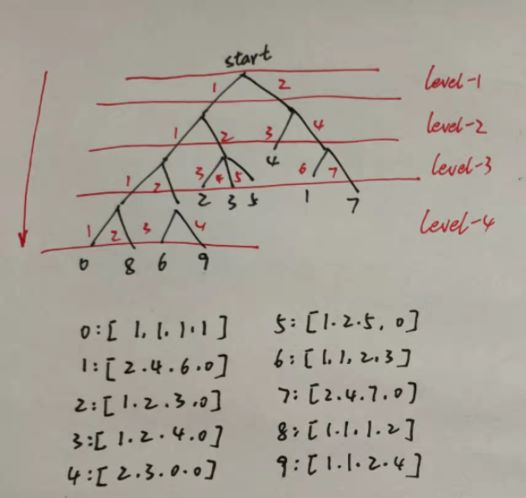

Where 0,1,...9 (in black) at the end of each branch represents the class label. The red 1,2,...7 indicates the path. The path of each class is given by the index of branches along its path, like class 4 is given by branch 2 at level 1, branch 3 at level 2, and no branches in level 3 and level 4, so the index is 0.

I chose the feature dimension to be 2, so it can be drawn in 2D plane. Accually I want the feature dimension to be a variable, a hyper parameter we can tune. But in this special case of feature dimension equals 2, I initiated the tree label by calculating angels.

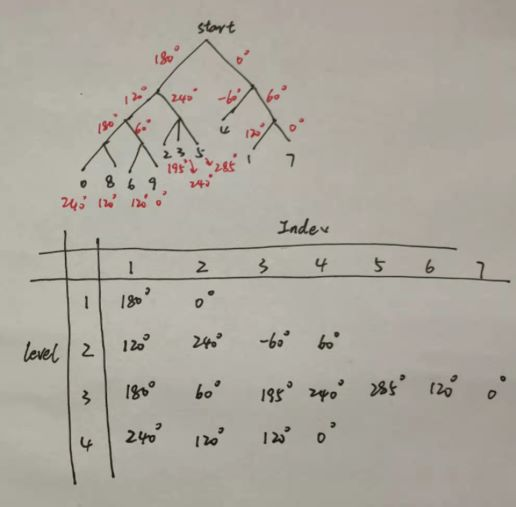

To plot the tree, I indexed each node.

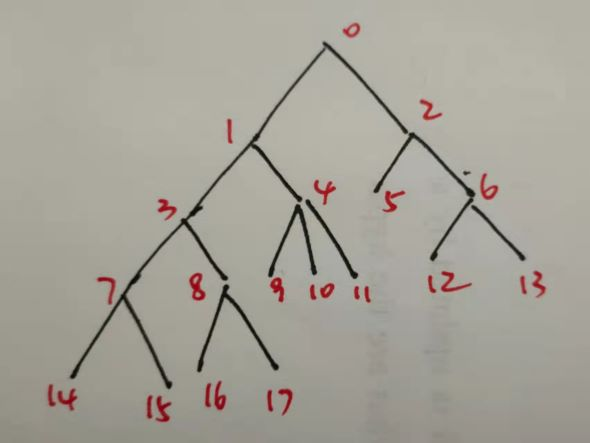

# Make Label

In [3]:
label_index = torch.tensor([[1,1,1,1],[2,4,6,0],
               [1,2,3,4],[1,2,4,0],
               [2,3,0,0],[1,2,5,0],
               [1,1,2,3],[2,4,7,0],
               [1,1,1,2],[1,1,2,4]])

tree_angel = torch.tensor([[180,0,0,0,0,0,0],
              [120,240,-60,60,0,0,0],
              [180,60,195,240,285,120,0],
              [240,120,120,0,0,0,0]])

tree_length = [1,0.5,0.2,0.1]

ndepth = 4
max_branch = 7
nclass = 10
w_tree = 0.01

nIters = 60

device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [4]:
# Calculate vector for each branch
tree_vec = torch.zeros(ndepth,max_branch,2)
for i in range(ndepth):
  for j in range(max_branch):
    angel = tree_angel[i,j]/180*math.pi
    tree_vec[i,j,0] = math.cos(angel)
    tree_vec[i,j,1] = math.sin(angel)

In [5]:
# Create the label vector using path and tree branch
def make_label_vector(tree_vec):
  label_vec = torch.zeros(nclass,2)
  for i in range(nclass):
    for j in range(ndepth):
      vec_ind = label_index[i,j]-1
      label_vec[i,:] += tree_length[j]*tree_vec[j,vec_ind,:]
  return label_vec
label_vec = make_label_vector(tree_vec)

In [6]:
# draw tree shape
def draw_tree_shape(tree_vec, tree_length, label_vec, line_color='k', dot_color='r'):
  tree_pts = torch.zeros(18,2)
  tree_pts[0,:] = torch.tensor([0,0])
  tree_pts[1,:] = tree_pts[0,:] + tree_vec[0,0,:]*tree_length[0]
  tree_pts[2,:] = tree_pts[0,:] + tree_vec[0,1,:]*tree_length[0]
  tree_pts[3,:] = tree_pts[1,:] + tree_vec[1,0,:]*tree_length[1]
  tree_pts[4,:] = tree_pts[1,:] + tree_vec[1,1,:]*tree_length[1]
  tree_pts[5,:] = tree_pts[2,:] + tree_vec[1,2,:]*tree_length[1]
  tree_pts[6,:] = tree_pts[2,:] + tree_vec[1,3,:]*tree_length[1]
  tree_pts[7,:] = tree_pts[3,:] + tree_vec[2,0,:]*tree_length[2]
  tree_pts[8,:] = tree_pts[3,:] + tree_vec[2,1,:]*tree_length[2]
  tree_pts[9,:] = tree_pts[4,:] + tree_vec[2,2,:]*tree_length[2]
  tree_pts[10,:] = tree_pts[4,:] + tree_vec[2,3,:]*tree_length[2]
  tree_pts[11,:] = tree_pts[4,:] + tree_vec[2,4,:]*tree_length[2]
  tree_pts[12,:] = tree_pts[6,:] + tree_vec[2,5,:]*tree_length[2]
  tree_pts[13,:] = tree_pts[6,:] + tree_vec[2,6,:]*tree_length[2]
  tree_pts[14,:] = tree_pts[7,:] + tree_vec[3,0,:]*tree_length[3]
  tree_pts[15,:] = tree_pts[7,:] + tree_vec[3,1,:]*tree_length[3]
  tree_pts[16,:] = tree_pts[8,:] + tree_vec[3,2,:]*tree_length[3]
  tree_pts[17,:] = tree_pts[8,:] + tree_vec[3,3,:]*tree_length[3]

  plt.plot([tree_pts[0,0],tree_pts[1,0]],[tree_pts[0,1],tree_pts[1,1]],line_color)
  plt.plot([tree_pts[0,0],tree_pts[2,0]],[tree_pts[0,1],tree_pts[2,1]],line_color)
  plt.plot([tree_pts[1,0],tree_pts[3,0]],[tree_pts[1,1],tree_pts[3,1]],line_color)
  plt.plot([tree_pts[1,0],tree_pts[4,0]],[tree_pts[1,1],tree_pts[4,1]],line_color)
  plt.plot([tree_pts[2,0],tree_pts[5,0]],[tree_pts[2,1],tree_pts[5,1]],line_color)
  plt.plot([tree_pts[2,0],tree_pts[6,0]],[tree_pts[2,1],tree_pts[6,1]],line_color)
  plt.plot([tree_pts[3,0],tree_pts[7,0]],[tree_pts[3,1],tree_pts[7,1]],line_color)
  plt.plot([tree_pts[3,0],tree_pts[8,0]],[tree_pts[3,1],tree_pts[8,1]],line_color)
  plt.plot([tree_pts[4,0],tree_pts[9,0]],[tree_pts[4,1],tree_pts[9,1]],line_color)
  plt.plot([tree_pts[4,0],tree_pts[10,0]],[tree_pts[4,1],tree_pts[10,1]],line_color)
  plt.plot([tree_pts[4,0],tree_pts[11,0]],[tree_pts[4,1],tree_pts[11,1]],line_color)
  plt.plot([tree_pts[6,0],tree_pts[12,0]],[tree_pts[6,1],tree_pts[12,1]],line_color)
  plt.plot([tree_pts[6,0],tree_pts[13,0]],[tree_pts[6,1],tree_pts[13,1]],line_color)
  plt.plot([tree_pts[7,0],tree_pts[14,0]],[tree_pts[7,1],tree_pts[14,1]],line_color)
  plt.plot([tree_pts[7,0],tree_pts[15,0]],[tree_pts[7,1],tree_pts[15,1]],line_color)
  plt.plot([tree_pts[8,0],tree_pts[16,0]],[tree_pts[8,1],tree_pts[16,1]],line_color)
  plt.plot([tree_pts[8,0],tree_pts[17,0]],[tree_pts[8,1],tree_pts[17,1]],line_color)
  for i in range(18):
    plt.scatter(tree_pts[i,0], tree_pts[i,1],c=dot_color)
  for i in range(10):
    plt.text(label_vec[i,0], label_vec[i,1] ,str(i),fontsize=20, verticalalignment="bottom", horizontalalignment="right")
  plt.text(0, 0 ,'start', fontsize=20, verticalalignment="top", horizontalalignment="center")
  plt.xlim(-2,2) 
  plt.ylim(-1,1)
  plt.title('The broccoli-like label')

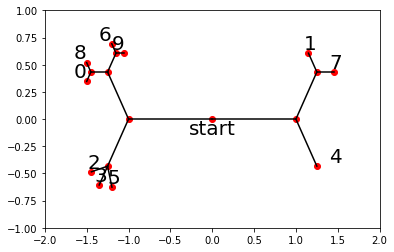

In [7]:
draw_tree_shape(tree_vec, tree_length, label_vec)

# Train

In [8]:
from torchvision import datasets, models
import torch.nn as nn

In [9]:
ResNet50 = models.resnet50(pretrained=False)
fc_inputs = ResNet50.fc.in_features
ResNet50.fc = nn.Sequential(
    nn.Linear(fc_inputs,256),
    nn.ReLU(),
    nn.Linear(256,10),
    nn.ReLU(),
    nn.Linear(10,2))

In [10]:
from torchvision import transforms

transform = transforms.Compose([transforms.ToTensor()])

In [11]:
data_train = datasets.CIFAR10(root = "./data/", train = True, transform=transform, download = True)
data_test = datasets.CIFAR10(root="./data/", train = False, transform=transform)
train_loader = torch.utils.data.DataLoader(dataset=data_train, batch_size = 10000, shuffle = True, drop_last=True)
test_loader = torch.utils.data.DataLoader(dataset=data_test, batch_size = 10000, shuffle = True, drop_last=True)

Files already downloaded and verified


In [12]:
def train_epoch(epoch, data_loader, model, loss_func, optimizer):
  for (X, y) in data_loader:
    label = label_vec[y.reshape(-1,1),:].squeeze().to(device)
    optimizer.zero_grad()
    output = model.forward(X.to(device))
    loss = loss_func(output, label)
    loss_hist[epoch] += loss
    loss.backward()
    optimizer.step()
  if (epoch+1)%5 == 0:
    print('Round', str(epoch+1)+'/'+str(nIters),', Loss: ', round(loss_hist[epoch].item(),5))

In [ ]:
# update tree vector
delta_tree_vec = torch.zeros(ndepth,max_branch,2)

In [ ]:
tree_vec = tree_vec*(1 - w_tree) + w_tree * delta_tree_vec
label_vec = make_label_vector(tree_vec)

In [13]:
model = ResNet50.to(device)

loss_func = nn.MSELoss()
optmizer = torch.optim.Adam(params=model.parameters(), lr=1e-4)

run_name = 'run-'+ str(time.time())
result_path = path+'/results/' + run_name + '/'
train_val_metrics_path = result_path + 'train_val_metrics/'
model_path = result_path + 'saved_model.pt'
if not os.path.exists(result_path):
    os.makedirs(result_path)
    os.mkdir(train_val_metrics_path)

loss_hist = torch.zeros(nIters).to(device)

for epoch in range(0, nIters):
  train_epoch(epoch, train_loader, model, loss_func, optmizer)

torch.save(model.state_dict(), model_path)

Round 5/100 , Loss:  4.1173
Round 10/100 , Loss:  1.57749
Round 15/100 , Loss:  0.63309
Round 20/100 , Loss:  0.32107
Round 25/100 , Loss:  0.15266
Round 30/100 , Loss:  0.09248
Round 35/100 , Loss:  0.05585
Round 40/100 , Loss:  0.04134
Round 45/100 , Loss:  0.02652
Round 50/100 , Loss:  0.01745
Round 55/100 , Loss:  0.01826
Round 60/100 , Loss:  0.01404
Round 65/100 , Loss:  0.01261
Round 70/100 , Loss:  0.01115
Round 75/100 , Loss:  0.01371
Round 80/100 , Loss:  0.01059
Round 85/100 , Loss:  0.00906
Round 90/100 , Loss:  0.01281
Round 95/100 , Loss:  0.00849
Round 100/100 , Loss:  0.00623


Text(0.5, 1.0, 'Training Loss')

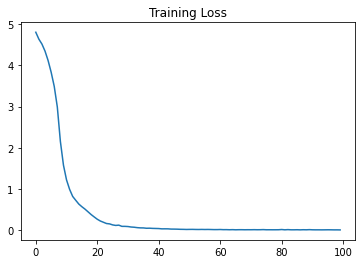

In [14]:
plt.plot(torch.arange(nIters), loss_hist.cpu().detach().numpy())
plt.title('Training Loss')

# Test

In [15]:
def vector_to_prediction(output, label_vec):
  # output (B, feature_dim)
  # label_vec (N, feature_dim)

  diff = output.unsqueeze(1) - label_vec.cuda().unsqueeze(0) #(B, N, feature_dim)
  diff = torch.sum(diff**2,2)
  return torch.argmin(diff,dim=1)

In [16]:
def test_model(train_loader, test_loader, model, loss_func, result_path):
  # Evaluate model on test set
  out_path = result_path + '/'
  test_preds, train_preds = [], []
  train_losses, test_losses = [], []
  num_correct_test = 0
  num_correct_train = 0

  for X,y in train_loader:
    with torch.no_grad():
      output_vector = model(X.to(device))
      label_vector = label_vec[y.reshape(-1,1),:].squeeze().to(device)

      prediction = vector_to_prediction(output_vector, label_vec)
      loss = loss_func(output_vector, label_vector)
      train_preds.append(prediction)
      train_losses.append(loss.item())
      #print(prediction == y.to(device))
      num_correct_train += int(torch.sum(prediction == y.to(device)))
  for X,y in test_loader:
    with torch.no_grad():
      output_vector = model(X.to(device))
      label_vector = label_vec[y.reshape(-1,1),:].squeeze().to(device)

      prediction = vector_to_prediction(output_vector, label_vec)
      loss = loss_func(output_vector, label_vector)
      test_preds.append(prediction)
      test_losses.append(loss.item())
      num_correct_test += int(torch.sum(prediction == y.to(device)))

  train_loss = np.mean(train_losses)
  train_acc = num_correct_train/50000
  test_loss = np.mean(test_losses)
  test_acc = num_correct_test/10000

  #print('Performance Metrics for epoch ' + str(epoch_num) + ':')
  print('train loss: ' + str(round(train_loss,3)))
  print('test loss: ' + str(round(test_loss,3)))
  print('train accuracy: ' + str(round(train_acc*100,3))+'%')
  print('test accuracy: ' + str(round(test_acc*100,3))+'%')

  with open(result_path + 'test_model.csv', 'w') as csvfile:
    fieldnames = ['train_loss', 'train_acc', 'test_loss', 'test_acc']
    writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
    writer.writeheader()
    writer.writerow({'train_loss': train_loss, 'train_acc': train_acc, 'test_loss': test_loss, 'test_acc': test_acc})

In [17]:
test_model(train_loader, test_loader, model, loss_func, train_val_metrics_path)

train loss: 0.001
test loss: 1.245
train accuracy: 97.626%
test accuracy: 19.71%


# Compaire

In [75]:
ResNet50_base = models.resnet50(pretrained=False)
fc_inputs = ResNet50_base.fc.in_features
ResNet50_base.fc = nn.Sequential(
    nn.Linear(fc_inputs,256),
    nn.ReLU(),
    nn.Linear(256,10),
    nn.ReLU(),
    nn.Linear(10,2),
    nn.ReLU(),
    nn.Linear(2,10))

ResNet50_base = ResNet50_base.to(device)

In [76]:
nIters_base = 60
optimizer_base = torch.optim.Adam(params=ResNet50_base.parameters(), lr=1e-4)
loss_hist_base = torch.zeros(nIters_base).to(device)

data_train_base = datasets.CIFAR10(root = "./data/", train = True, transform=transform, download = True)
data_test_base = datasets.CIFAR10(root="./data/", train = False, transform=transform)
train_loader_base = torch.utils.data.DataLoader(dataset=data_train_base, batch_size = 10000, shuffle = True, drop_last=True)
test_loader_base = torch.utils.data.DataLoader(dataset=data_test_base, batch_size = 10000, shuffle = True, drop_last=True)

Files already downloaded and verified


In [77]:
def softmax_loss(pred, label):
  # pred: (B,C)
  # label: (C)
  B = pred.shape[0]

  expo = torch.exp(pred)
  score = expo/torch.sum(expo,axis=1).reshape(-1,1)
  the_score = score[torch.arange(B).reshape(1,B),label].squeeze()
  return -torch.sum(torch.log(the_score+1e-5))/B

In [78]:
for epoch in range(nIters_base):
  for (X, y) in train_loader_base:
    X = X.to(device)
    y = y.to(device)

    output = ResNet50_base.forward(X)
    loss = softmax_loss(output, y)
    loss_hist_base[epoch] += loss

    optimizer_base.zero_grad()
    loss.backward()
    optimizer_base.step()

  if (epoch+1)%5 == 0:
    print('Round', str(epoch+1)+'/'+str(nIters_base),', Loss: ', round(loss_hist_base[epoch].item(),5))

Round 5/60 , Loss:  11.73607
Round 10/60 , Loss:  11.73332
Round 15/60 , Loss:  11.7306


KeyboardInterrupt: ignored

Text(0.5, 1.0, 'Training Loss for ResNet Baseline')

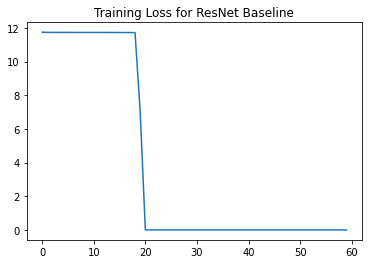

In [79]:
plt.plot(torch.arange(nIters_base), loss_hist_base.cpu().detach().numpy())
plt.title('Training Loss for ResNet Baseline')

In [80]:
num_correct_test_base = 0
total_num = 0

for X,y in train_loader_base:
  with torch.no_grad():
    y = y.to(device)
    X = X.to(device)

    output = ResNet50_base(X)
    pred = torch.argmax(output, axis=1)
    
    num_correct_test_base += int(torch.sum(pred == y))
    total_num += X.shape[0]
train_acc = num_correct_test_base/total_num



num_correct_test_base = 0
total_num = 0

for X,y in test_loader_base:
  with torch.no_grad():
    y = y.to(device)
    X = X.to(device)

    output = ResNet50_base(X)
    pred = torch.argmax(output, axis=1)
    
    num_correct_test_base += int(torch.sum(pred == y))
    total_num += X.shape[0]
test_acc = num_correct_test_base/total_num

In [81]:
print('Base Line train accuracy: ' + str(round(train_acc*100,3))+'%')
print('Base Line test accuracy: ' + str(round(test_acc*100,3))+'%')

Base Line train accuracy: 10.0%
Base Line test accuracy: 10.0%
